In [1]:
import pandas as pd
import numpy as np
import random
import math
import re
from scipy.special import psi #digamma function
from scipy.special import polygamma #derivative of digamma function
from scipy.special import loggamma
from IPython.display import display
import numpy.random
from nltk.tokenize import wordpunct_tokenize
import sys
import csv
import nltk
from nltk.corpus import stopwords #import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import time
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1234)
meanchangethresh = 1e-3
MAXITER = 10000

In [3]:
def getVocab(file):
	#getting vocab dictionary from a csv file (nostopwords)'''
	vocab = dict()
	with open(file, 'r') as infile:
		reader = csv.reader(infile)
		for index, row in enumerate(reader):
			vocab[row[0]] = index

	return vocab

In [4]:
def getDocs(file_path):
    with open(file_path,encoding="utf-8") as f:
        docs=f.readlines()
        
    return(docs)

In [5]:
def dirichlet_expectation(a):
    if (len(a.shape)==1):
        return (psi(a)-psi(np.sum(a)))
    return (psi(a)-psi(np.sum(a,1))[:,np.newaxis])


In [6]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [7]:
def parseDocument(doc, vocab):
    #preprocessing document data
	wordslist = list()
	countslist = list()
	doc = doc.lower()
	tokens = nltk.word_tokenize(doc)#wordpunct_tokenize(doc)
	remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    
	tokens=[re.sub(remove_chars,"",x.lower()) for x in tokens]
	tokens=[x for x in tokens if x!='']
    # 词形还原
	tagged_sent = pos_tag(tokens)
	wnl = WordNetLemmatizer()
	lemmas_sent = []
	for tag in tagged_sent:
		wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
		lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) 
	tokens=lemmas_sent

	dictionary = dict()
	for word in tokens:
		if word in vocab:
			wordtk = vocab[word]
			if wordtk not in dictionary:
				dictionary[wordtk] = 1
			else:
				dictionary[wordtk] += 1

	wordslist.append(dictionary.keys())
	countslist.append(dictionary.values())
	return (wordslist[0], countslist[0])

In [8]:
def plottrace(x, Y, K, n):
	for i in range(K):
		plt.plot(x, Y[i], label = "Topic %i" %(i+1))

	plt.xlabel("Number of Iterations")
	plt.ylabel("Probability of Each topic")
	plt.legend()
	plt.title("Trace plot for topic probabilities")
	plt.savefig("plot_%i_%i.png" %(K, n))

In [9]:
class SVILDA():
	def __init__(self, vocab, K, D, alpha, eta, tau, kappa, docs, iterations, parsed = False):
		self._vocab = vocab
		self._V = len(vocab)
		self._K = K
		self._D = D
		self._alpha = alpha
		self._eta = eta
		self._tau = tau
		self._kappa = kappa
		self._lambda = 1* np.random.gamma(100., 1./100., (self._K, self._V))
		self._Elogbeta = dirichlet_expectation(self._lambda)
		self._expElogbeta = np.exp(self._Elogbeta)
		self._docs = docs
		self.ct = 1 
		self._iterations = iterations
		self._parsed = parsed
		print (self._lambda.shape)
		print (self._lambda)        
		self._trace_lambda = {} #record lambda in every 10th iteration
		for i in range(self._K):
			#print(self.computeProbabilities()[i])            
			self._trace_lambda[i] = [self.computeProbabilities()[i]]
		self._x = [0]
		self._ELBO = list()


	def updateLocal(self, doc): #word_dn is an indicator variable with dimension V?????
		print("Updating local parameters")
		(words, counts) = doc
		newdoc = []
		N_d = sum(counts) #total number of words in this doc
		phi_d = np.zeros((self._K, N_d))
		gamma_d = np.ones(self._K)#np.random.gamma(100., 1./100., (self._K))
		Elogtheta_d = dirichlet_expectation(gamma_d)
		expElogtheta_d = np.exp(Elogtheta_d)
		for i, item in enumerate(counts):
			for j in range(item):
				newdoc.append(list(words)[i])
		assert len(newdoc) == N_d, "error" #当len不等于N_d时，触发异常
        
		inner_iteration = 20
		inner_thresh = 0.1

		for i in range(inner_iteration):
			for m, word in enumerate(newdoc):
				phi_d[:, m] = np.multiply(expElogtheta_d, self._expElogbeta[:, word]) #+ 1e-100
				phi_d[:, m] = phi_d[:, m]/np.sum(phi_d[:, m]) #normalize

			gamma_new = self._alpha + np.sum(phi_d, axis = 1)
			meanchange = np.mean(abs(gamma_d - gamma_new))

			if (meanchange < inner_thresh):
				break

			gamma_d = gamma_new
			print(gamma_d)
			Elogtheta_d = dirichlet_expectation(gamma_d)
			expElogtheta_d = np.exp(Elogtheta_d)

		newdoc = np.asarray(newdoc)

		return phi_d, newdoc, gamma_d

	def updateGlobal(self, phi_d, doc):
		print ('updating global parameters')
		lambda_d = np.zeros((self._K, self._V))

		for k in range(self._K):
			phi_dk = np.zeros(self._V)
			for m, word in enumerate(doc):
					# print word
				phi_dk[word] += phi_d[k][m] 
			lambda_d[k] = self._eta + self._D * phi_dk
		#print("this is lambda_d",lambda_d)
		rho = (self.ct + self._tau) **(-self._kappa)
		#print("this is lambda before updating",self._lambda)
		self._lambda = (1-rho) * self._lambda + rho * lambda_d
		print(self._lambda)
		self._Elogbeta = dirichlet_expectation(self._lambda)
		self._expElogbeta = np.exp(self._Elogbeta)

#		if self.ct>-1:#% 10 == 9:
#			for i in range(self._K):
#				self._trace_lambda[i].append(self.computeProbabilities()[i])
#			self._x.append(self.ct)
            
	def runSVI(self):
		#random.seed(1234)

		for i in range(self._iterations):			
			randint = random.randint(0, self._D-1)
			print ("ITERATION", i, " running document number ", randint)
			if self._parsed == False:
				doc = parseDocument(self._docs[randint],self._vocab)
				phi_doc, newdoc, gamma_d = self.updateLocal(doc)
				self.updateGlobal(phi_doc, newdoc)
                
				if self.ct>-1:#% 10 == 9:
					for i in range(self._K):
						print("This is trace lambda:",self.computeProbabilities()[i],self.ct)                        
						self._trace_lambda[i].append(self.computeProbabilities()[i])
					self._x.append(self.ct)
                    
				ELBO = self.Calculate_doc_L(newdoc,phi_doc,gamma_d)
				self._ELBO.append(ELBO)                
				self.ct += 1


	def computeProbabilities(self):

		prob_topics = np.sum(self._lambda, axis = 1)
		prob_topics = prob_topics/np.sum(prob_topics)
		return prob_topics

	def getTopics(self, docs = None):
		prob_topics = self.computeProbabilities()
		prob_words = np.sum(self._lambda, axis = 0)

		if docs == None:
			docs = self._docs
		results = np.zeros((len(docs), self._K))
		for i, doc in enumerate(docs):
			parseddoc = parseDocument(doc, self._vocab)

			for j in range(self._K):
				aux = [self._lambda[j][word]/prob_words[word] for word in parseddoc[0]]
				doc_probability = [np.log(aux[k]) * list(parseddoc[1])[k] for k in range(len(aux))]
				results[i][j] = sum(doc_probability) + np.log(prob_topics[j])
		finalresults = np.zeros(len(docs))
		for k in range(len(docs)):
			finalresults[k] = np.argmax(results[k])
		return finalresults, prob_topics

	def calcPerplexity(self, docs = None):
		perplexity = 0.
		doclen = 0.
		if docs == None:
			docs =  self._docs
		for doc in docs:
			parseddoc = parseDocument(doc, self._vocab)
			_, newdoc, gamma_d = self.updateLocal(parseddoc)
			approx_mixture = np.dot(gamma_d, self._lambda)
			# print n.shape(approx_mixture)
			approx_mixture = approx_mixture / np.sum(approx_mixture)
			log_doc_prob = 0.
			for word in newdoc:
				log_doc_prob += np.log(approx_mixture[word])
			perplexity += log_doc_prob
			doclen += len(newdoc)
			# print perplexity, doclen
		perplexity = np.exp( - perplexity / doclen)
		print (perplexity)
		return perplexity

	def plotTopics(self):
		plottrace(self._x, self._trace_lambda, self._K, self._iterations)
			

            
	def Calculate_doc_L(self,new_doc,phi_d,gamma_d):
		l=0
        
		l += loggamma(self._K*self._alpha) - self._K*loggamma(self._alpha) - loggamma(sum(gamma_d)) + sum(loggamma(gamma_d))
		l += sum((self._alpha-gamma_d) * dirichlet_expectation(gamma_d))
		for k in range(self._K):
			l += loggamma(self._V*self._eta) - self._V*loggamma(self._eta) - loggamma(sum(self._lambda[k]))+sum(loggamma(self._lambda[k]))
			l += sum((self._eta-self._lambda[k]) * dirichlet_expectation(self._lambda[k]))
		for n in range(len(new_doc)):
			l += sum(phi_d[:,n] * dirichlet_expectation(gamma_d))
			l += sum(phi_d[:,n] * np.log(phi_d[:,n]))
			for k in range(self._K):
				for j in range(self._V):
					if j == new_doc[n]:
						l += phi_d[k][n]*dirichlet_expectation(self._lambda[k])[j]
            
                
		return(l)

In [10]:
def Generate_Data(num_topic,voc_size,num_doc,xi,alpha,eta):
    num_word=np.repeat(xi,num_doc)#np.random.poisson(xi,num_doc) #number of words in each document
    
    beta=np.zeros([num_topic,voc_size])
    for i in range(num_topic):
        beta[i]=np.random.dirichlet(eta)
    
    theta=np.zeros([num_doc,num_topic])
    for d in range(num_doc):
        theta[d]=np.random.dirichlet(alpha)
    
    doc={}
    for d in range(num_doc):
        W=np.zeros([voc_size,num_word[d]])
        for n in range(num_word[d]):
            z=np.random.multinomial(1,theta[d])
            topic_index=np.where(z==1)[0][0]
            w=np.random.multinomial(1,beta[topic_index,])
            W[:,n]=w
        doc[d]=W
                            
    return doc,beta,theta




np.random.seed(12345)
K=2
V=8
D=1000
xi=100
true_alpha=[0.05 for i in range(K)]
true_eta=[1.0 for i in range(V)]
docs,true_beta,true_theta=Generate_Data(K,V,D,xi,true_alpha,true_eta)

vocab={'i': 0,
 'new': 1,
 'percent': 2,
 'people': 3,
 'year': 4,
 'two': 5,
 'million': 6,
 'president': 7}
key_list=list(vocab.keys())
value_list=list(vocab.values())

new_docs=list()
for d in range(D):
    new_doc = ""
    Nd = len(docs[d][0])
    for n in range(Nd):
        pos = np.where(docs[d][:,n]==1)[0][0]
        new_doc += " "+key_list[pos]
    new_docs.append(new_doc)
    




In [11]:
real_docs = getDocs("Abstract_data.txt")
real_vocab = getVocab("vocab.csv")
key_list=list(real_vocab.keys())
value_list=list(real_vocab.values())

In [12]:
random.seed(1235)
start=time.time()
k=2
alpha=0.1
iterations=100
d=len(new_docs)
test=SVILDA(vocab = vocab, K = k, D = d, alpha = alpha, eta = 0.2, tau = 0.7, kappa = 0.7, docs = new_docs, iterations= iterations)
test.runSVI()
end=time.time()
print ("Running time:",str(end-start),"seconds")

(2, 8)
[[1.11872836 1.18605976 0.85159602 1.12428573 1.00870019 1.00058906
  1.16451012 1.1266794 ]
 [0.97042231 0.9969065  0.94180615 1.15245833 1.03986051 1.14129844
  0.90933979 1.0965638 ]]
ITERATION 0  running document number  930
Updating local parameters
[53.31045967 46.88954033]
[56.48366173 43.71633827]
[59.59554839 40.60445161]
[62.62475628 37.57524372]
[65.55303169 34.64696831]
[68.36544506 31.83455494]
[71.05042358 29.14957642]
[73.5996325 26.6003675]
[76.00774154 24.19225846]
[78.2721133 21.9278867]
[80.39244755 19.80755245]
[82.37040958 17.82959042]
[84.20926481 15.99073519]
[85.91353516 14.28646484]
[87.48868713 12.71131287]
[88.9408569 11.2591431]
[90.27661397  9.92338603]
[91.50276232  8.69723768]
[92.62617599  7.57382401]
[93.65366498  6.54633502]
updating global parameters
[[12320.84242128  6502.31349419  1259.69879287  5094.19299648
   2545.13178646  7532.54400752 20949.23471731  8327.56349663]
 [  785.1519838    396.04512485   120.61461071   424.71363063
    214.74

ITERATION 10  running document number  724
Updating local parameters
[77.80273652 22.39726348]
[89.71489796 10.48510204]
[95.02460708  5.17539292]
[97.61761894  2.58238106]
[98.95962286  1.24037714]
[99.66732973  0.53267027]
[100.00963999   0.19036001]
updating global parameters
[[ 7679.06835065  6567.57111656  8435.10380568 21191.58498374
    385.4181315   1207.78016054  4713.55517455  6538.82595928]
 [11475.34112205  1680.78003703   771.91654712   646.2985979
   3823.36486084  3336.82916982 15690.01806477  4855.9045643 ]]
This is trace lambda: 0.5729219594167525 11
This is trace lambda: 0.4270780405832476 11
ITERATION 11  running document number  357
Updating local parameters
[70.93079523 29.26920477]
[82.15304082 18.04695918]
[88.47522114 11.72477886]
[92.31969269  7.88030731]
[94.81335136  5.38664864]
[96.51269374  3.68730626]
[97.7138057  2.4861943]
[98.58451704  1.61548296]
[99.22349547  0.97650453]
[99.68554498  0.51445502]
[99.98400724  0.21599276]
[100.09425211   0.10574789]
u

[84.89438365 15.30561635]
[90.32700292  9.87299708]
[93.34908668  6.85091332]
[95.22893705  4.97106295]
[96.50682129  3.69317871]
[97.43784954  2.76215046]
[98.15400211  2.04599789]
[98.72833588  1.47166412]
[99.20206303  0.99793697]
[99.59460993  0.60539007]
[99.90034003  0.29965997]
[100.07242552   0.12757448]
updating global parameters
[[10102.30905854  7533.46325972  9742.50344674 21832.45713008
     86.17020392   817.94585134  2891.96844984  6336.18464392]
 [10757.11531291  1411.96671608   936.72443159   711.53263625
   3983.65885495  3857.36302226 14422.55477631  4420.43182139]]
This is trace lambda: 0.594355136494235 24
This is trace lambda: 0.40564486350576506 24
ITERATION 24  running document number  623
Updating local parameters
[32.57191878 67.62808122]
[22.29261767 77.90738233]
[16.51064887 83.68935113]
[13.12284726 87.07715274]
[11.01502357 89.18497643]
[ 9.62734968 90.57265032]
[ 8.66940555 91.53059445]
[ 7.98222179 92.21777821]
[ 7.47384726 92.72615274]
[ 7.08834053 93.1

[90.74353099  9.45646901]
[91.62043422  8.57956578]
[92.27219768  7.92780232]
[92.77294498  7.42705502]
[93.16801904  7.03198096]
[93.48653524  6.71346476]
[93.74796113  6.45203887]
[93.96576535  6.23423465]
[94.14954121  6.05045879]
[94.30629488  5.89370512]
[94.44125554  5.75874446]
[94.55840111  5.64159889]
[94.66080886  5.53919114]
updating global parameters
[[ 8036.81509792  7324.68052122  8038.23766701 19340.74301045
     28.57621577   557.09601736  2497.39928241  5815.4060999 ]
 [13253.45767416  1611.06973089  1106.07842809   759.09160373
   4574.00964193  5004.93336234 16918.30610293  5086.5210107 ]]
This is trace lambda: 0.5166353466402613 36
This is trace lambda: 0.4833646533597386 36
ITERATION 36  running document number  652
Updating local parameters
[75.17298482 25.02701518]
[87.27599133 12.92400867]
[93.15775033  7.04224967]
[96.23397565  3.96602435]
[97.96193009  2.23806991]
[98.98651779  1.21348221]
[99.60922801  0.59077199]
[99.96513649  0.23486351]
[100.09277189   0.1

Updating local parameters
[70.22294282 29.97705718]
[80.47362707 19.72637293]
[85.96488272 14.23511728]
[89.21048905 10.98951095]
[91.30597035  8.89402965]
[92.75987562  7.44012438]
[93.82895621  6.37104379]
[94.65327421  5.54672579]
[95.31450676  4.88549324]
[95.86307484  4.33692516]
[96.33167555  3.86832445]
[96.74246007  3.45753993]
[97.11105092  3.08894908]
[97.4488981  2.7511019]
[97.76471675  2.43528325]
[98.0653886  2.1346114]
[98.35652264  1.84347736]
[98.64275277  1.55724723]
[98.92773372  1.27226628]
[99.21357776  0.98642224]
updating global parameters
[[8.72080951e+03 7.86947475e+03 1.00100642e+04 2.07892525e+04
  1.30021915e+01 6.92504540e+02 2.55208041e+03 7.32614596e+03]
 [1.17141580e+04 1.40034409e+03 8.33984885e+02 8.02823775e+02
  3.79645240e+03 4.21826148e+03 1.48087482e+04 4.43435931e+03]]
This is trace lambda: 0.5798350080413608 48
This is trace lambda: 0.42016499195863916 48
ITERATION 48  running document number  535
Updating local parameters
[75.09179792 25.108202

[ 0.94744418 99.25255582]
[ 0.67759104 99.52240896]
[ 0.41673608 99.78326392]
[ 0.2008128 99.9991872]
updating global parameters
[[8.36690997e+03 6.96812316e+03 9.25399616e+03 2.05558355e+04
  9.32505454e+00 5.48061066e+02 2.42958161e+03 7.01050540e+03]
 [1.29177981e+04 1.94738102e+03 7.74822458e+02 9.52599523e+02
  3.42052441e+03 4.15374307e+03 1.60441503e+04 4.63882057e+03]]
This is trace lambda: 0.5514665182958315 58
This is trace lambda: 0.44853348170416857 58
ITERATION 58  running document number  369
Updating local parameters
[32.99238401 67.20761599]
[24.11000029 76.08999971]
[19.61467739 80.58532261]
[17.2279864 82.9720136]
[15.89361474 84.30638526]
[15.11791122 85.08208878]
[14.65488992 85.54511008]
[14.37371488 85.82628512]
[14.20108262 85.99891738]
[14.09435312 86.10564688]
updating global parameters
[[8.01247185e+03 6.64233147e+03 8.86405662e+03 1.97180026e+04
  8.97521588e+00 5.23461673e+02 2.32477868e+03 6.69403141e+03]
 [1.36558628e+04 1.99240271e+03 8.20395115e+02 1.018

[  0.14654208 100.05345792]
updating global parameters
[[7.18862350e+03 6.14915351e+03 7.46042313e+03 1.68646865e+04
  6.21158314e+00 4.96724137e+02 2.07176330e+03 6.05257696e+03]
 [1.56216310e+04 2.26250159e+03 1.10485756e+03 1.16291608e+03
  4.46258082e+03 4.65621685e+03 1.84821448e+04 5.95420868e+03]]
This is trace lambda: 0.4629144953801423 69
This is trace lambda: 0.5370855046198577 69
ITERATION 69  running document number  993
Updating local parameters
[25.8121272 74.3878728]
[13.20646359 86.99353641]
[ 7.20519012 92.99480988]
[ 4.17926103 96.02073897]
[ 2.50210386 97.69789614]
[ 1.4861617 98.7138383]
[ 0.82909319 99.37090681]
[ 0.39752034 99.80247966]
[  0.15631941 100.04368059]
updating global parameters
[[6.82384424e+03 5.83711920e+03 7.08185206e+03 1.60088823e+04
  5.90652416e+00 4.71527703e+02 1.96664184e+03 5.74544900e+03]
 [1.61482991e+04 2.24918690e+03 1.15028367e+03 1.15464869e+03
  4.69284927e+03 4.72441889e+03 1.96248549e+04 6.31175912e+03]]
This is trace lambda: 0.439

[85.06096824 15.13903176]
[85.74047703 14.45952297]
[86.1921086 14.0078914]
[86.49611443 13.70388557]
[86.70255002 13.49744998]
[86.84358165 13.35641835]
updating global parameters
[[6.66245933e+03 5.85600571e+03 6.90979803e+03 1.62285200e+04
  5.23813165e+00 5.93544021e+02 1.80979769e+03 5.28597818e+03]
 [1.64132426e+04 2.36577430e+03 1.26021323e+03 1.03065142e+03
  4.64159724e+03 5.43907685e+03 1.91744848e+04 6.32351342e+03]]
This is trace lambda: 0.43351386601760916 81
This is trace lambda: 0.5664861339823909 81
ITERATION 81  running document number  479
Updating local parameters
[28.67149161 71.52850839]
[17.06366761 83.13633239]
[11.20809556 88.99190444]
[ 8.06926668 92.13073332]
[ 6.2247255 93.9752745]
[ 5.04126607 95.15873393]
[ 4.22238396 95.97761604]
[ 3.61862461 96.58137539]
[ 3.14891551 97.05108449]
[ 2.76621156 97.43378844]
[ 2.44147493 97.75852507]
[ 2.15569868 98.04430132]
[ 1.89568387 98.30431613]
[ 1.65167706 98.54832294]
[ 1.41599991 98.78400009]
[ 1.18230141 99.017698

ITERATION 94  running document number  89
Updating local parameters
[75.49138136 24.70861864]
[86.59687207 13.60312793]
[91.71197732  8.48802268]
[94.4316291  5.7683709]
[96.07812415  4.12187585]
[97.18204301  3.01795699]
[97.98278796  2.21721204]
[98.59986891  1.60013109]
[99.09689261  1.10310739]
[99.50621371  0.69378629]
[99.83363985  0.36636015]
[100.04502978   0.15497022]
updating global parameters
[[7.72284647e+03 5.95312769e+03 7.95946739e+03 1.84211916e+04
  3.57648466e+00 5.17803483e+02 1.87100675e+03 5.40916716e+03]
 [1.45672995e+04 2.23089372e+03 1.27105869e+03 9.50434996e+02
  4.49709685e+03 5.28160605e+03 1.76979036e+04 5.64693804e+03]]
This is trace lambda: 0.47857508201093024 95
This is trace lambda: 0.5214249179890698 95
ITERATION 95  running document number  450
Updating local parameters
[26.93880053 73.26119947]
[14.39109545 85.80890455]
[ 8.07983907 92.12016093]
[ 4.77736436 95.42263564]
[ 2.91961153 97.28038847]
[ 1.79102228 98.40897772]
[ 1.05740361 99.14259639]
[ 

In [13]:
beta=test._lambda
for i in range(k):
    beta[i]=beta[i]/np.sum(beta[i])
pd.DataFrame(np.around(beta,3))

,0,1,2,3,4,5,6,7
0,0.161,0.124,0.164,0.384,0.000,0.012,0.039,0.116
1,0.279,0.042,0.024,0.017,0.088,0.102,0.338,0.110


In [14]:
pd.DataFrame(np.around(true_beta,3))

,0,1,2,3,4,5,6,7
0,0.276,0.040,0.021,0.024,0.087,0.094,0.347,0.110
1,0.160,0.123,0.160,0.377,0.001,0.013,0.041,0.124


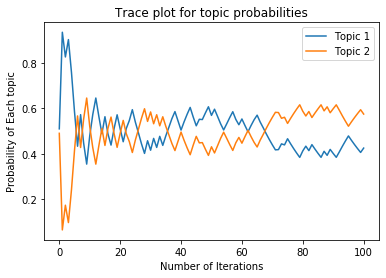

In [15]:
test.plotTopics()

In [16]:
#Calculate the top 5 words in each topic
topic_words=[]
max_num=10
for i in range(0,K):
    #topic_words.append([])
    sorted_beta_index=beta[i,:].argsort()
    topicword=[]
    for j in sorted_beta_index:
        topicword.insert(0,key_list[j])
    topic_words.append(topicword[0:min(max_num,len(topicword))])
topic_words

[['people', 'percent', 'i', 'new', 'president', 'million', 'two', 'year'],
 ['million', 'i', 'president', 'two', 'year', 'new', 'percent', 'people']]

In [17]:
test._trace_lambda[0]

[0.509878094925303,
 0.9354904935484863,
 0.8265873959435829,
 0.903095041273157,
 0.7589356246007155,
 0.5844899882580707,
 0.433255828115297,
 0.5724144354194097,
 0.44695028697955197,
 0.35446076907879187,
 0.47881753250474113,
 0.5729219594167525,
 0.6456106462954136,
 0.564379983840607,
 0.488512908019776,
 0.5633128095146337,
 0.48689240455895855,
 0.4382973970963329,
 0.5108470787441767,
 0.5717373370353139,
 0.5101381944454231,
 0.4529978110677854,
 0.5112661914143927,
 0.5461991640031534,
 0.594355136494235,
 0.5390207903936041,
 0.49219152881716066,
 0.44400937333454493,
 0.4016145997444794,
 0.4573910482980505,
 0.41573772295978534,
 0.46775988144300884,
 0.4280334053141928,
 0.47682003039960025,
 0.4369753809252679,
 0.47908142077058136,
 0.5166353466402613,
 0.5547440711522862,
 0.5858576300468686,
 0.5451136458539543,
 0.5043853001473189,
 0.5407868287201828,
 0.573963458968619,
 0.6042480096830181,
 0.5619740883414084,
 0.5232597195579197,
 0.5519853426163092,
 0.5508238

In [18]:
true_theta[989]

array([0.53087479, 0.46912521])